In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('activity.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

C:\Users\jenny\AppData\Local\Temp/ipykernel_31512/2320953125.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('activity.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2537 non-null   object 
 1   review        2537 non-null   object 
 2   score         2537 non-null   object 
 3   real_date     2537 non-null   object 
 4   year          2537 non-null   float64
 5   month         2537 non-null   float64
 6   type          2272 non-null   object 
 7   dataset       2500 non-null   object 
dtypes: float64(2), object(6)
memory usage: 158.7+ KB


In [3]:
df['type'].unique()

array([' 가족', ' 비지니스', ' 개인', nan, ' 커플', ' 친구'], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,6] in [' 친구',' 가족',' 커플']:
        df.iloc[i,6] = 'no_solo'
    elif df.iloc[i,6] in [' 비지니스', np.NaN]:
        df.iloc[i,6] = np.NaN
    elif df.iloc[i,6] in [' 개인']:
        df.iloc[i,6]='solo'

In [5]:
df['type'].unique()

array(['no_solo', nan, 'solo'], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2149 entries, 0 to 2535
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2149 non-null   object 
 1   review        2149 non-null   object 
 2   score         2149 non-null   object 
 3   real_date     2149 non-null   object 
 4   year          2149 non-null   float64
 5   month         2149 non-null   float64
 6   type          2149 non-null   object 
 7   dataset       2114 non-null   object 
dtypes: float64(2), object(6)
memory usage: 151.1+ KB


In [7]:
df[df['dataset'].isnull()]

,review_title,review,score,real_date,year,month,type,dataset
49,"코미디, 액션으로 가득한 엔터테인먼트를 통해 자리를 장식 할 수 있습니다!",우리가 좌석을 확보하기 위해 우리 여행에 앞서 온라인으로 표를 예약하러 갔을 정도로...,5,2018년 10월,2018.0,10.0,no_solo,NaN
173,리움 펼치지 이루어가는 기업이기 때문이었습니다 현대적,"""현대""및 ""현대"" 조항을 종종 서로 바꿔서, 하지만 사람들은 기민한 정보는 알이 ...",5,2015년 2월,2015.0,2.0,no_solo,NaN
193,팩 인바강은,덕분에 즐거운 시간을! 내 마음에 드는 것은 제가 할 수 있는 미술관이 있을 때는 ...,5,2015년 5월,2015.0,5.0,solo,NaN
218,아름다운 박물관을 방문하는,이 박물관에서 볼 수 있는 호텔을 찾는데 itaewan 확인했습니다. 한강 에서 짧...,4,2015년 10월,2015.0,10.0,solo,NaN
283,There is mixing place with Korean traditions a...,"저희 부부(유아 동반)는 할인대상이 아니어서 1인당 10,000원짜리 표를 끊고 상...",4,2017년 5월,2017.0,5.0,no_solo,NaN
354,꼭 모든 관광,찾은 큰 기념물이 좋았죠 박물관. 저는 조언에 날씨좋은날 에 대한 복잡한 (적어도 ...,5,2015년 1월,2015.0,1.0,no_solo,NaN
393,시간 여행을!,전쟁기념관은 정말 놀라웠습니다. 그래서 문제가 많은 생각에 결국 하루에 레이아웃 및...,5,2015년 3월,2015.0,3.0,solo,NaN
629,민족 주의 와 한국 전쟁,"여기까지 오는 데, 내리지 통해ns, #12 싱출구가 을 (에 표시). 직진 하는 ...",4,2015년 8월,2015.0,8.0,solo,NaN
634,서울에 있는 (무료) 꼭 관광명소,서울에 100% 무료 방문하기 좋은 곳! 좋은 하루 반나절 또는 전체를 통해 길을 ...,5,2015년 8월,2015.0,8.0,no_solo,NaN
702,매혹적인 박물관 - 역사의 외국인 한국 전쟁 & 감사를 저하,세번째 방문이 마지막 방문 기념 박물관에서 할 수 있습니다. 제가 원하는 것 입니다...,5,2015년 9월,2015.0,9.0,no_solo,NaN


In [8]:
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2535
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2114 non-null   object 
 1   review        2114 non-null   object 
 2   score         2114 non-null   object 
 3   real_date     2114 non-null   object 
 4   year          2114 non-null   float64
 5   month         2114 non-null   float64
 6   type          2114 non-null   object 
 7   dataset       2114 non-null   object 
dtypes: float64(2), object(6)
memory usage: 148.6+ KB


In [9]:
#솔로/비솔로 데이터 구분
#솔로
condition = (df.type=='solo')
df2=df.loc[condition]

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 2 to 2535
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  410 non-null    object 
 1   review        410 non-null    object 
 2   score         410 non-null    object 
 3   real_date     410 non-null    object 
 4   year          410 non-null    float64
 5   month         410 non-null    float64
 6   type          410 non-null    object 
 7   dataset       410 non-null    object 
dtypes: float64(2), object(6)
memory usage: 28.8+ KB


In [11]:
df2['score'].unique()

array(['3', '4', '5', '2'], dtype=object)

In [12]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [13]:
#솔로 데이터 토큰화
tokenized_list_solo = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_solo.append(tokenize_korean_text(a[text]))

In [14]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=1,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_solo


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 410
Total words: 12954
Vocab size: 3364


In [15]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 410 docs, 12954 words
| Total Vocabs: 3367, Used Vocabs: 3364
| Entropy of words: 7.02906
| Entropy of term-weighted words: 7.62432
| Removed Vocabs: 박물관 있는 한국
| Metadata of docs and its distribution
|  3: 25
|  4: 114
|  5: 265
|  2: 6
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.84732
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 1 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal distribution fo

==== Coherence : c ====
Average: 0.5247591052949429 
Per Topic: [0.4998418360948563, 0.46574482321739197, 0.5068840384483337, 0.5751775801181793, 0.5442465573549271, 0.5298081815242768, 0.560935327410698, 0.4782986119389534, 0.5371686935424804, 0.5656104490160943, 0.5274073272943497, 0.5356324255466461, 0.5143959850072861, 0.5291782766580582, 0.5357916057109833, 0.5390692532062531, 0.5365910977125168, 0.5395142912864686, 0.5030193775892258, 0.4708663672208786]


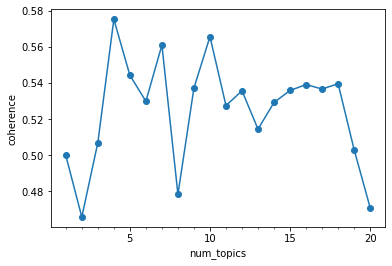

In [16]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [17]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=4, alpha=0.1, eta=0.01, min_cf=1,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_solo

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 410
Total words: 12954
Vocab size: 3364
Topic #0	전시, 시간, 방문, 모든, 입니다, 사람, 많은, 역사, 전쟁, 서울
Topic #1	사진, 미술관, 문화재, 작품, 국립, 친구, 전쟁기념관, 직원, 근처, 시대
Topic #2	정보, 투어, 최고, 가이드, 하루, 해야, 경험, 건물, 경우, 아주
Topic #3	전쟁, 거대한, 대해, 가지, 영어, 설명, 흥미로운, 매우, 합니다, 아주


In [18]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 410 docs, 12954 words
| Total Vocabs: 3367, Used Vocabs: 3364
| Entropy of words: 7.02906
| Entropy of term-weighted words: 7.62432
| Removed Vocabs: 박물관 있는 한국
| Metadata of docs and its distribution
|  3: 25
|  4: 114
|  5: 265
|  2: 6
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.77721
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 1 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 4 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal distribution f

In [19]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*2+a[1]*3+a[2]*4+a[3]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,2score,3score,4score,5score,total,re_score
0,0.052025,0.238157,0.574799,0.983586,1.848567,4.346960
1,0.067213,0.204727,0.295400,0.230340,0.797680,3.863588
2,0.179014,0.118825,0.294746,0.502991,1.095576,4.023858
3,0.128533,0.161597,0.307200,0.333384,0.930715,3.908372


In [20]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,2score,3score,4score,5score,total,re_score,word_list
0,0.052025,0.238157,0.574799,0.983586,1.848567,4.346960,"[전시, 시간, 방문, 모든, 입니다, 사람, 많은, 역사, 전쟁, 서울]"
1,0.067213,0.204727,0.295400,0.230340,0.797680,3.863588,"[사진, 미술관, 문화재, 작품, 국립, 친구, 전쟁기념관, 직원, 근처, 시대]"
2,0.179014,0.118825,0.294746,0.502991,1.095576,4.023858,"[정보, 투어, 최고, 가이드, 하루, 해야, 경험, 건물, 경우, 아주]"
3,0.128533,0.161597,0.307200,0.333384,0.930715,3.908372,"[전쟁, 거대한, 대해, 가지, 영어, 설명, 흥미로운, 매우, 합니다, 아주]"


In [21]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 있는, 박물관, 한국, 다른, 모든
전시	0.009311911650002003
시간	0.008560586720705032
방문	0.00809760857373476
모든	0.007991249673068523
입니다	0.007975760847330093
사람	0.007828728295862675
많은	0.007755799684673548
역사	0.007536240853369236
전쟁	0.0074447207152843475
서울	0.0074234637431800365

== Topic #1 ==
Labels: 한글 박물관, 많아, 문화재, 식당, 소장
사진	0.01189877837896347
미술관	0.010424623265862465
문화재	0.007757696323096752
작품	0.007555256597697735
국립	0.007503131404519081
친구	0.007340753450989723
전쟁기념관	0.007092811167240143
직원	0.00698855658993125
근처	0.006824499927461147
시대	0.006698832381516695

== Topic #2 ==
Labels: rd, 푸드코트, 있는, 요리, 에어컨
정보	0.010741602629423141
투어	0.01052640751004219
최고	0.010473683476448059
가이드	0.010307475924491882
하루	0.007155216298997402
해야	0.0070999180898070335
경험	0.007046572398394346
건물	0.006966634187847376
경우	0.006761722732335329
아주	0.006484635639935732

== Topic #3 ==
Labels: 동상, 최근, 선물, 참여, 박물관
전쟁	0.010154439136385918
거대한	0.009727402590215206
대해	0.009418207220733166
가지	0.008988070301711

In [22]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_solo
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    410 non-null    object
 1   score   410 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [23]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
2,"[완벽한, 비언, 표시, 당신, 여행, 하는, 동안, 가지, 문화, 활동, 해야, ...",5,NaN
6,"[재미있긴, 하지만, 너무, 시끄럽다, 안전하고, 편안하게, 하기, 위해, 귀마개,...",4,NaN
7,"[좋은, 시간, 이었습니다, 신선한, 공연, 이었어요, 아이, 약간, 지루했어요, ...",4,NaN
8,"[재밌고, 재미있는, 멋진, 혼자, 보러, 갔고, 그것, 완전히, 즐겼다, 성인, ...",4,NaN
12,"[방문, 하기, 좋은, 자카르타, 파트너, 입니다, 섹스, 그러나, Cluntchy...",5,NaN
...,...,...,...
401,"[아주, 재밌어, 흥미, 롭다, 그리고, 방문, 거기, 즐겼다, 정말, 사진, 찍는...",5,NaN
403,"[장난, 재미있고, 모든, 있지만, 거기, 일이, 별로, 없습니다, 당신, 그대로,...",4,NaN
405,"[사용, 하면, 차가운, 사진, 동영상, 박물관, 여러, 보았습니다, 그러나, 박물...",5,NaN
406,"[굳이, 아는, 동생, 하도, 가자고, 해서, 갔는데, 굳이, 여길, 싶을, 정도,...",3,NaN


In [24]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     2       1
1         0.0     3       7
2         0.0     4      30
3         0.0     5      84
4         1.0     3       5
5         1.0     4      16
6         1.0     5      20
7         2.0     2       2
8         2.0     3       4
9         2.0     4      12
10        2.0     5      22
11        3.0     3       2
12        3.0     4      13
13        3.0     5      29
